Cristian Villazhannay <br>
Robotic Manipulation <br>
November 30, 2023 <br>
Final Project

In [350]:
#Import the necessary packages. 
import numpy as np 
import modern_robotics as mr
from math import sin,cos
import matplotlib.pyplot as plt

In [351]:
def TestJointLimits(jointAngles):
    '''
    TestJointLimits is meant to take in a 
    '''
    boolArr = np.full((5,), False)
    
    #check to see if there are any joint limit violations
    if(jointAngles[4] < -2.87 or jointAngles[4] > 2.87):     #joint 5
        boolArr[4] = True
    
    if(jointAngles[3] < -1.78 or jointAngles[3] > 1.78):     #joint 4
        boolArr[3] = True

    if(jointAngles[2] > 2.54 or jointAngles[2] < -2.63):     #joint 3
        boolArr[2] = True 

    if (jointAngles[1] < -1.13 or jointAngles[1] > 1.57):
        boolArr[1] = True

    if (jointAngles[0] < -2.9 or jointAngles[0] > 2.9):
        boolArr[0] = True
    
    return boolArr

In [352]:
def csVector(traj, grip_state):
    '''
    csVector takes in a trajectory list as output from the ScrewTrajectory or
    Cartestian Trajectory in modern_robotics. It then converts it into a 13 vector
    of the form

    T_ se = [[r_11, r_12, r_13, p_x],
             [r_21, r_22, r_23, p_y],
             [r_31, r_32, r_33, p_z],
             [   0,    0,    0,   1]]

    [r_11, r_12, r_13, r_21, r_22, r_23, r_31, r_32, r_33, p_x, p_y, p_z, grip_state] 

    Parameters
    ----------
    traj : list
        a N shaped list, where each entry is a 4 x 4 configuration state. 

    grip_state: int
        either 0 or 1, relays whether the gripper is open or not. 

    Output
    ------
    vec : np.array
        a (N, 13) shaped array that represents the configuration states 
        and the gripper state.
    '''
    #convert the list into a numpy array.
    trajArr = np.asarray(traj)

    #create an empty list that we will initialize into. 
    vec = np.empty((trajArr.shape[0], 13))

    #Create the 13-vector by flattening the rotation matrix and appending the position at the end. 
    #grip state is called at the end. 
    for i in range(trajArr.shape[0]):
        trans = np.append(np.copy(trajArr[i,0:3,0:3].flatten()), trajArr[i,0:3,-1])
        vec[i,:] = np.append(trans, grip_state)
    
    return vec

In [353]:
def TrajectoryGenerator(T_se, initial_cube, desired_cube, grasp, standoff, time, k = 1, method= "cubic"): 
    '''
    TrajectoryGenerator will generate the reference trajectory for the end effector frame {e}.
    
    Parameters
    -----------
    T_se            : np.array
        A (4,4) shaped array representing the initial configuration of the end-effector
        in the reference trajectory 

    intial_cube     : np.array
        A (4,4) shaped array representing the cube's initial configuration. 

    desired_cube    : np.array
        A (4,4) shaped array representing the cube's final configuration

    grasp           : np.array
        A (4,4) shaped array representing the end-effectors configuration relative to the cube
        when it is grasping the cube

    standoff        : np.array
        A (4,4) shaped array representing the configuration of the end effector relative to the cube. 

    k               : int 
        Number of reference configuration per 0.01 seconds. Must be an integer that is greater than 1. Will default to 1 if not input. 

    time            : int
        Total time in seconds for the trajectory to move. 

    method          : str
        String input that declares what order polynomial we will be using. Will default to cubic. 

    Outputs
    --------
    trajectory      : np.array
        An (N,13) shaped array that represents the N configurations along the entire concatenated eight
        segment reference trajectory. 
    '''

    ##INPUT VARIABLE CHECKS
    #Make sure that k meets the req. 
    if type(k) != int or k < 1:
        raise ValueError("k can only be a integer that is >= 1")
    
    #Make sure that our method will be cubic or quintic. 
    match method: 
        case "cubic":
            method = 3
        case "quintic":
            method = 5
        case _: 
            raise ValueError("method must be cubic or quintic.")

    ##TRAJECTORY INPUT GENERATION
    #Calculate the time that each step will take.
    timeSlice = int((time-1.26)/6 * 100)/100

    #Dump any remainder in the final step. 
    rem = time - ((int(timeSlice*100)/100) * 6 + 1.23)

    #Configuration of the standoff/grasp configurations in the reference frame. 
    initialsT_se = initial_cube @ standoff
    initialgT_se = initial_cube @ grasp

    desiredsT_se = desired_cube @ standoff
    desiredgT_se = desired_cube @ grasp


    ##TRAJECTORY GENERATION
    #{1} Move the gripper from the initial configuration to the standoff
    trajOne = mr.ScrewTrajectory(T_se, initialsT_se,timeSlice, timeSlice*k*100, method)
    csvSnip = csVector(trajOne, 0)

    #{2} Move the gripper from the standoff to the grasp.
    trajTwo = mr.ScrewTrajectory(trajOne[-1], initialgT_se,timeSlice, timeSlice*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajTwo, 0)))

    #{3} Close the gripper for 0.63 seconds
    trajThree = mr.ScrewTrajectory(trajTwo[-1], trajTwo[-1],0.63, 0.63*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajThree, 1)))

    #{4} A trajectory to move the gripper back up to the "standoff" configuration
    trajFour = mr.ScrewTrajectory(trajThree[-1], initialsT_se,timeSlice, timeSlice*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajFour, 1)))

    #{5} A trajectroy to move the gripper to the final configuration "standoff"
    trajFive = mr.ScrewTrajectory(trajFour[-1], desiredsT_se,timeSlice, timeSlice*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajFive, 1)))

    #{6} A trajectory to move the gripper to the final configuration
    trajSix = mr.ScrewTrajectory(trajFive[-1], desiredgT_se,timeSlice, timeSlice*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajSix, 1)))

    #{7} Open the gripper for 0.63 seconds
    trajSeven = mr.ScrewTrajectory(trajSix[-1], desiredgT_se, 0.63, 0.63*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajSeven, 0)))

    #{8} Move back to the standoff. 
    trajEight = mr.ScrewTrajectory(trajSeven[-1], desiredsT_se,timeSlice + rem, timeSlice*k*100, method)
    csvSnip = np.vstack((csvSnip,csVector(trajEight, 0)))

    ##CSV CREATION
    #Compile our trajectory.
    np.savetxt('theta' + '.csv', csvSnip, delimiter=',')
    return csvSnip


In [354]:
def FeedbackControl(currentactEffector, currentrefEffector, nextrefEffector, pGain, iGain, dt, totalError):
    '''
    Parameters
    ----------
    currentactEffector: np.array
        An (4,4) shaped np.array representing the current actual end effector configuration
    
    currentrefEffector: np.array
        An (4,4) shaped np.array representing the current end effector reference configuration
    
    nextrefEffector: np.array
        The end-effector reference configuration at the next timestep in the reference trajectory
    
    pGain: np.array
        A (6,6) shaped array representing the proportional gain matrix.
    
    iGain: np.array
        A (6,6) shaped array representing the integral gain matrix.
    
    dt: float
        A number that represents the timestep between the reference trajectory configurations. 

    Output
    -------
    v: np.array
        The commanded end effector twist V expressed in the end effector frame. 
    ''' 
    #SOLVE FOR THE FEEDFORWARD CONTROL LAW
    #Solve for [AdX^-1X_d]
    invX = mr.TransInv(currentactEffector)
    adj = mr.Adjoint(invX @ currentrefEffector)

    #Solve for V_d 
    invX_d = mr.TransInv(currentrefEffector)
    vdse3 = 1/dt * mr.MatrixLog6(invX_d @ nextrefEffector)
    v_d = mr.se3ToVec(vdse3)

    #Solve for X_err
    xerr_se3 = mr.MatrixLog6(invX @ currentrefEffector)
    x_err = mr.se3ToVec(xerr_se3)

    #SOLVE FOR THE COMMANDED VECTOR
    v = adj @ v_d + pGain @ x_err + iGain @ (totalError * dt)
    
    return v, x_err


In [355]:
def flat2mat(flat): 
    '''
    flat2mat converts a flat matrix with a gripper state back into a transfromation matrix.

    Parameters
    ----------
    flat: np.array
        an (13,) shaped array representing the current configuration and gripper state.

    i.e. [r_11, r_12, r_13, r_21, r_22, r_23, r_31, r_32, r_33, p_x, p_y, p_z, grip_state] 

    Output
    ------
    mat: np.array
        a (4x4) array that repressents the current configuration state

    grip_state: int
        an integer representing the open/close configuration of the gripper
    '''
    #return the rotation matrix elements to their respective places. 
    mat = np.concatenate((flat[0:9].reshape(3,3),flat[9:-1][:,None]), axis=1)

    #add the final row 
    mat = np.vstack((mat, np.array([0, 0, 0, 1])[None, :]))
    grip = flat[-1]

    return mat, grip

In [368]:
def wjcontrols(currConfig, v, index="run"):
    '''
    Parameters
    ----------
    currConfig   : np.array
        a (12,) vector representing the current configuration of the robot. 
    i.e [chassis, arm, wheel angles] 
    
    v: np.array
        a (6,) vector that represents the commanded end effector twist in the end effector frame

    Output
    ------
    wheeljoints: np.array
        a (9,) vector representing the commanded wheel and joint torques 
        i.e. [wheel , joints]
    '''
    #FIND THE BODY JACOBIAN
    #extract the current joint angles 
    thetalist= currConfig[3:8]

    #list of the screw axes in the body frame
    blist = np.array([[    0,       0,       0,       0, 0],
                      [    0,      -1,      -1,      -1, 0],
                      [    1,       0,       0,       0, 1],
                      [    0, -0.5076, -0.3526, -0.2176, 0],
                      [0.033,       0,       0,       0, 0],
                      [    0,       0,       0,       0, 0]])
    
    #calculate the body jacobian based on the joint angles
    jb = mr.JacobianBody(blist, thetalist)
    
    #if there are indices then we zero out the violating angles.
    if index != "run": 
        for i in index:
            casted = int(i)
            jb[:, casted] = 0

    #FIND THE BASE JACOBIAN
    #find the F vector
    r = 0.0475
    l = 0.235
    w = 0.15
    F = (r/4) * np.array([[-1/(l+w), 1/(l+w), 1/(l+w), -1/(l+w)],
                          [       1,       1,       1,        1],
                          [      -1,       1,      -1,        1]])

    #create the F6 vector
    F6 = np.vstack((np.zeros((2,4)), F, np.zeros((1,4))))

    #create the transformation we need to find the 
    T_b0 = np.array([[1, 0, 0, 0.1662],
                     [0, 1, 0,      0],
                     [0, 0, 1, 0.0026],
                     [0, 0, 0,      1]])
    
    M_0e = np.array([[1, 0, 0, 0.033],
                 [0, 1, 0, 0],
                 [0, 0, 1, 0.6546],
                 [0, 0, 0, 1]])
    
    invT_b0 = mr.TransInv(T_b0)
    T_0e = mr.FKinBody(M_0e, blist, thetalist )
    invT_0e = mr.TransInv(T_0e)

    jbase = mr.Adjoint(invT_0e @ invT_b0) @ F6

    #FIND THE MOBILE MANIPULATOR JACOBIAN
    je = np.hstack((jbase, jb))

    #FIND THE COMMANDED WHEEL AND JOINT TORQUES
    #to avoid singularites, we implement a limit on the smallest value that can exist before we do the SVD decomp. 
    wheeljoints = np.linalg.pinv(je, rcond=1e-3) @ v

    return wheeljoints


In [369]:
def NextState(currentConfig, u, dt, maxjointSpeed, maxwheelSpeed):
    '''
    NextState will simulate the kinematics for the youBot. 

    Parameters
    ----------
    currentConfig   : np.array
        a (12,) vector representing the current configuration of the robot. 
        i.e [chassis, arm, wheel angles] 

    u               : np.array
        a (9,) vector representing the wheel speeds and the arm speeds.
        i.e [u_1 , u_2, u_3, u_4, tdot_1, tdot_2, tdot_3, tdot_4]

    dt              : float
        a number that represents the timestep being taken. 

    maxjointSpeed        : float
        a number that represents the maximum angular speed of the robot arm joints. 

    maxwheelSpeed      : float
        a number that represents the maximum wheel speed of the robot.

    Outputs
    -------
    newConfig: np.array
        a 12, vector representing the configuration of the robot dt seconds later.
    '''

    #INPUT VARIABLE CHECKS

    #SPLIT OUR INPUTS INTO USEABLE VECTORS
    #currentConfig breakdown
    chassisConfig = currentConfig[0:3]
    armConfig = currentConfig[3:8]
    wheelAngle = currentConfig[8:]

    #u breakdown
    wheelSpeed = u[0:4]
    jointSpeed = u[4:]

    #make sure that we are not over the maximum limits. 
    wheelSpeed[wheelSpeed > maxwheelSpeed] = maxwheelSpeed
    wheelSpeed[wheelSpeed < -1 * maxwheelSpeed] = -1 * maxwheelSpeed
    jointSpeed[jointSpeed < -1 * maxjointSpeed] = -1 * maxjointSpeed
    jointSpeed[jointSpeed > maxjointSpeed] = maxjointSpeed

    #UPDATE THE NEW JOINT ANGLES + WHEEL ANGLES
    newarmConfig = armConfig + jointSpeed * dt 
    newwheelAngle = wheelAngle + wheelSpeed * dt 

    #HARDCODED KINEMATICS
    r = 0.0475
    l = 0.235
    w = 0.15
    F = (r/4) * np.array([[-1/(l+w), 1/(l+w), 1/(l+w), -1/(l+w)],
                          [       1,       1,       1,        1],
                          [      -1,       1,      -1,        1]])
    
    #UPDATE THE NEW CHASSIS CONFIGURATION
    #find the chassis planar twist
    Vb = F @ (wheelSpeed * dt)
    w_bz = Vb[0]
    v_bx = Vb[1]
    v_by = Vb[2]

    #find the new dq
    if w_bz == 0:
        dq_b = np.array([0, v_bx, v_by])
    else: 
        dq_b = np.array([w_bz,
                         (v_bx * sin(w_bz) + v_by * (cos(w_bz) - 1))/w_bz,
                         (v_by * sin(w_bz) + v_bx * (1 - cos(w_bz)))/w_bz
                         ])
        
    #transform the dq_b to dq_s 
    phi_k = currentConfig[0]
    rotMat = np.array([[1,          0,           0],
                       [0, cos(phi_k), -sin(phi_k)],
                       [0, sin(phi_k),  cos(phi_k)]])
    
    dq_s = rotMat @ dq_b

    newchassisConfig = chassisConfig + dq_s

    #COMPILE ALL THE CONFIGURATIONS
    newConfig = np.hstack((newchassisConfig, newarmConfig, newwheelAngle))

    return newConfig

In [370]:
def currT_se(config): 
    #screw axes in the body frame 
    blist = np.array([[    0,       0,       0,       0, 0],
                      [    0,      -1,      -1,      -1, 0],
                      [    1,       0,       0,       0, 1],
                      [    0, -0.5076, -0.3526, -0.2176, 0],
                      [0.033,       0,       0,       0, 0],
                      [    0,       0,       0,       0, 0]])

    #end effector frame relative to the body frame in home configuration
    M_0e = np.array([[1, 0, 0,  0.033],
                    [0, 1, 0,      0],
                    [0, 0, 1, 0.6546],
                    [0, 0, 0,      1]])
    
    #find the current transformation matrices based on the robot configuration
    phi = config[0]
    X = config[1]
    Y = config[2]

    #configuration of the b frame relative to s frame
    T_sb = np.array([[cos(phi), -sin(phi), 0, X],
                    [sin(phi),  cos(phi), 0, Y],
                    [       0,         0, 1, 0.0963],
                    [       0,         0, 0, 1]])

    #fixed offset from the chassis frame 
    T_b0 = np.array([[1, 0, 0, 0.1662],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0.0026],
                    [0, 0, 0, 1]])

    #current actual end effector position 
    T_0e = mr.FKinBody(M_0e, blist, config[3:8])

    #robotic T_se
    actualT_se = T_sb @ T_b0 @ T_0e
    
    return actualT_se

In [371]:
def youBotCube(cubeInitial, cubeDesired, ybInitial, trajInitial, name, Kp=np.identity(6), Ki=np.identity(6)):
    '''
    Parameters
    ----------
    cubeInitial:np.array
        iniitial resting configuration in the world frame of the cube as (4,4) array

    desiredCube:np.array
        desired resting configuration of the cube in the world frame as (4,4) array

    ybInitial:np.array
        the initital configuration fo the youBot as (13,) array
        i.e. [chassis phi, chassis x, chassis y, J1, J2, J3, J4, J5, W1, W2, W3, W4, Gripper State]

    trajInitial:np.array
        initial T_se of the reference trajectory for the end effector frame as (4,4) array

    name: str
        name of the output csv trajectory data

    Optional
    ---------
    Kp: np.array
        the proportional gain for the controller as a (6,6) matrix. Default is np.identity(6)
    Ki: np.array
        the integral gain for the controller as (6,6) matrix. Default in np.identity(6)

    Outputs
    -------
    "name".csv : .CSV file
        A .csv file containing the configuration states.

    "name_error" : .CSV file
        A .csv file containing the error data for the 
    
    '''
    print("Generating trajectory ...")
    #CONSTANTS
    roty = np.array([[cos(1.04), 0, sin(1.04)],
                 [0, 1, 0],
                 [-sin(1.04), 0, cos(1.04)]])
    
    #The end effector grasp frame configuration relative to the cube. 
    grasp = np.array([[ 0, 0, 1, 0],
                    [ 0, 1, 0, 0],
                    [-1, 0, 0, 0],
                    [ 0, 0, 0, 1]])
    grasp[0:3,0:3] = roty @ grasp[0:3,0:3]

    #The end effector standoff frame configuration relative to the cube.
    standoff = np.array([[ 0, 0, 1,   0],
                    [ 0, 1, 0,   0],
                    [-1, 0, 0, 0.1],
                    [ 0, 0, 0,   1]])
    standoff[0:3,0:3] = roty @ standoff[0:3,0:3]
    
    #FIND THE INITIAL CONFIGURATION OF THE ROBOT
    actualT_se = currT_se(ybInitial)

    #GENERATE A REFERENCE TRAJECTORY 
    #Create the reference trajectory 
    refTraj = TrajectoryGenerator(trajInitial, cubeInitial, cubeDesired, grasp, standoff, 15)
    
    #LOOP OVER THE REFERENCE TRAJECTORY
    #initialize the current T_se with the actual T_se 
    currentT_se = np.copy(actualT_se)
    currConfig = np.copy(ybInitial[0:-1])

    #create a csvfile and errordata 
    csvoutput = np.copy(ybInitial)
    errordata = np.empty((refTraj.shape[0]-1, 6))
    totalerror = np.zeros((6,))

    #loop
    for i in range(refTraj.shape[0] - 1):
        #Extract the current + desired end effector position in the reference trajectory
        x_d, agrip = flat2mat(refTraj[i,:])
        x_dnext, bgrip = flat2mat(refTraj[i + 1,:])
        
        #Calculate the controls and solve for the commanded wheel and joint controls
        #Return the x_err so that we can plot the evolution of the error over time. 
        v, x_err = FeedbackControl(currentT_se, x_d, x_dnext, Kp, Ki, 0.01, totalerror)

        wjTorques = wjcontrols(currConfig,v)

        #allocate our error the appropriate position. 
        errordata[i,:] = x_err
        totalerror = totalerror + x_err

        #Enter a loop to find a solution. 
        loopcount = 0

        #Create a running count of what columns we need to zero out. 
        cancellation = np.array([])

        while True: 
            #create a configuration to test if we are violating joint limits in the next step. 
            testConfig =  NextState(currConfig[:], wjTorques, 0.01, 1e9, 1e9)

            #return whether or not joint were violated. 
            joints = TestJointLimits(testConfig[3:8])

            #if no joints were violated we break from the loop.
            if np.all(joints == False):
                break
            
            else: 
                #return the indices of all the True values. 
                index = np.nonzero(joints)

                #append items to the cancellation matrix. 
                cancellation = np.append(cancellation, index)

                #modify the Jacobian according to the new indices. 
                wjTorques = wjcontrols(currConfig, v, cancellation)
                testConfig =  NextState(currConfig[:], wjTorques, 0.01, 1e9, 1e9)

                #increase the loopcount
                loopcount += 1 
                if loopcount > 10:
                    raise ValueError("I'm stuck")


        currConfig = testConfig
        currentT_se = currT_se(currConfig)

        #add the new configuration to the csv output
        #remember to reattach the gripper state
        gripConfig = np.hstack((currConfig, agrip))
        csvoutput = np.vstack((csvoutput, gripConfig))

    #compile our trajectory and error data
    np.savetxt(name + '.csv', csvoutput, delimiter=',')
    np.savetxt(name + '_error.csv', errordata, delimiter=',')
    print("Trajectory generated!")
    return

In [372]:
# #TEST SCRIPT INPUTS HERE -----------------------------------------------------------------------------------
# #Initial configuration of the end effector reference trajectory
# T_se = np.array([[ 0.170, 0, 0.985, 0.387],
#                  [ 0, 1, 0,     0],
#                  [ -0.985, 0, 0.170, 0.570],
#                  [ 0, 0, 0,     1]])

# tran = np.identity((4))
# roty = np.array([[cos(0.785), 0, sin(0.785)],
#                  [0, 1, 0],
#                  [-sin(0.785), 0, cos(0.785)]])
# tran[0:3,0:3] = roty @ tran[0:3,0:3]
# tran[0,-1] = 0.2

# T_se = T_se @ tran

# #Intialize the initial and the final configurations of the cube. 
# T_isc = np.array([[ 1, 0, 0,     1],
#                   [ 0, 1, 0,     0],
#                   [ 0, 0, 1, 0.025],
#                   [ 0, 0, 0,     1]])

# T_dsc = np.array([[ 0, 1, 0,     0],
#                   [-1, 0, 0,    -1],
#                   [ 0, 0, 1, 0.025],
#                   [ 0, 0, 0,     1]])

# #The end effector grasp frame configuration relative to the cube. 
# T_gce = np.array([[ 0, 0, 1, 0],
#                   [ 0, 1, 0, 0],
#                   [-1, 0, 0, 0],
#                   [ 0, 0, 0, 1]])

# #The end effector standoff frame configuration relative to the cube.
# T_sce = np.array([[ 0, 0, 1,   0],
#                   [ 0, 1, 0,   0],
#                   [-1, 0, 0, 0.1],
#                   [ 0, 0, 0,   1]])

# #initial configuration
# initialRobot = np.array([0, 0, 0, 0, 0, 0.2, -1.6, 0, 0, 0, 0, 0, 0])

# #Gain Factors
# Kp = np.identity((6)) * 1
# Ki = np.identity((6)) * 1 
# # Kp = np.zeros((6,6))
# # Ki = np.zeros((6,6))

# #TEST SCRIPT BEGINE HERE-----------------------------------------------------------------------------------------
# #FIND THE INITIAL CONFIGURATION OF THE ROBOT
# actualT_se = currT_se(initialRobot)

# #GENERATE A REFERENCE TRAJECTORY 
# #Create the reference trajectory 
# refTraj = TrajectoryGenerator(T_se, T_isc, T_dsc, T_gce, T_sce, 15)

# #LOOP OVER THE REFERENCE TRAJECTORY
# #initialize the current T_se with the actual T_se 
# currentT_se = np.copy(actualT_se)
# currConfig = np.copy(initialRobot[0:-1])

# #create a csvfile and errordata 
# csvoutput = np.copy(initialRobot)
# errordata = np.empty((refTraj.shape[0]-1, 6))
# totalerror = np.zeros((6,))

# #loop
# for i in range(refTraj.shape[0] - 1):
#     #Extract the current + desired end effector position in the reference trajectory
#     x_d, agrip = flat2mat(refTraj[i,:])
#     x_dnext, bgrip = flat2mat(refTraj[i + 1,:])
    
#     #Calculate the controls and solve for the commanded wheel and joint controls
#     #Return the x_err so that we can plot the evolution of the error over time. 
#     v, x_err = FeedbackControl(currentT_se, x_d, x_dnext, Kp, Ki, 0.01, totalerror)

#     wjTorques = wjcontrols(currConfig,v)

#     #allocate our error the appropriate position. 
#     errordata[i,:] = x_err
#     totalerror = totalerror + x_err

#     #Calculate the new configuration using NextStep
#     currConfig = NextState(currConfig[:], wjTorques, 0.01, 1000, 1000)
#     currentT_se = currT_se(currConfig)

#     #add the new configuration to the csv output
#     #remember to reattach the gripper state
#     gripConfig = np.hstack((currConfig, agrip))
#     csvoutput = np.vstack((csvoutput, gripConfig))

# #compile our trajectory
# np.savetxt('theta' + '.csv', csvoutput, delimiter=',')

# How To 
To use this code, one should run all the cells with function definitions above. Then, one needs to call the function `youBotCube` with the following arguments: 


```python
    youBotCube(cubeInitial, cubeDesired, ybInitial, trajInitial, name, Kp, Ki)
    '''
    Parameters
    ----------
    cubeInitial:np.array
        iniitial resting configuration in the world frame of the cube as SE3 array (4,4)

    desiredCube:np.array
        desired resting configuration of the cube in the world frame as SE3 array (4,4)

    ybInitial:np.array
        the initial configuration of the youBot as (13,) array
        i.e. [chassis phi, chassis x, chassis y, J1, J2, J3, J4, J5, W1, W2, W3, W4, Gripper State]

    trajInitial:np.array
        initial T_se of the reference trajectory for the end effector frame as SE3 array (4,4)

    name: str
        name of the output csv trajectory data

    Optional
    ---------
    Kp: np.array
        the proportional gain for the controller as a (6,6) matrix. Default is np.identity(6)

    Ki: np.array
        the integral gain for the controller as (6,6) matrix. Default in np.identity(6)

    Outputs
    -------
    "name".csv : .CSV file
        A .csv file containing the configuration states. Will generate in the directory that the .ipynb is run in. 

    "name_error" : .CSV file
        A .csv file containing the error data. Will generate in the directory that the .ipynb is run in. 
    '''
```

    


# Example: Best Gains 
The best gains were accomplished using only a P controller.

$$

K_P = 
\begin{matrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{matrix}


\quad \quad \quad 


K_I = 
\begin{matrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{matrix}

$$


Generating trajectory ...


/var/folders/7w/_9tcnxcs6ld28_h3sl__ch380000gn/T/ipykernel_4876/2357832682.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index != "run":


Trajectory generated!


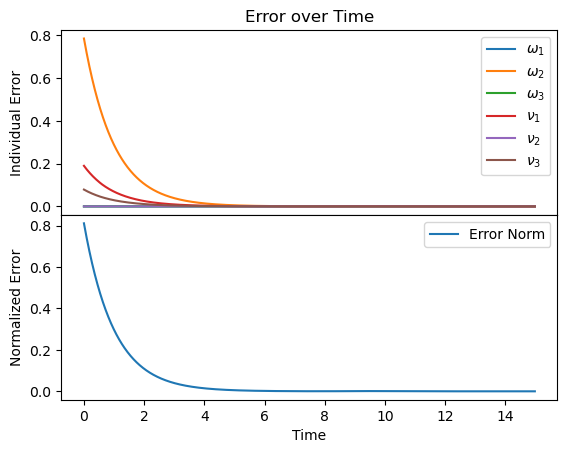

In [373]:
#FUNCTION INPUTS HERE -----------------
#Initial configuration of the end effector reference trajectory
T_se = np.array([[ 0.170, 0, 0.985, 0.387],
                 [ 0, 1, 0,     0],
                 [ -0.985, 0, 0.170, 0.570],
                 [ 0, 0, 0,     1]])

#Rotate the T_se to give us both 30 degree error in angular position and 0.2 error in planar positioning.
tran = np.identity((4))
roty = np.array([[cos(0.785), 0, sin(0.785)],
                 [0, 1, 0],
                 [-sin(0.785), 0, cos(0.785)]])
tran[0:3,0:3] = roty @ tran[0:3,0:3]
tran[0,-1] = 0.2
T_se = T_se @ tran

#Intialize the initial and the final configurations of the cube. 
T_isc = np.array([[ 1, 0, 0,     1],
                  [ 0, 1, 0,     0],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

T_dsc = np.array([[ 0, 1, 0,     0],
                  [-1, 0, 0,    -1],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

#initial configuration
initialRobot = np.array([0, 0, 0, 0, 0, 0.2, -1.6, 0, 0, 0, 0, 0, 0])

#CSV name 
name = "JointLimitbest"

#gains
kp = np.identity((6)) * 1
ki = np.identity((6)) * 0

#FUNCTION CALL ------------------------
youBotCube(T_isc, T_dsc, initialRobot, T_se, name, Kp=kp, Ki=ki)

#PLOT THE ERROR DATA ------------------
#import the error data
ename = name + "_error.csv"
errordata = np.loadtxt(ename, delimiter=",", dtype=float)
plotTime = np.asanyarray([*range(errordata.shape[0])]) * .01

#create a plot of the x_error for each individual vector item. 
fig, axs = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(plotTime, errordata[:,0], marker="none", label=r"$\omega_1$")
axs[0].plot(plotTime, errordata[:,1], marker="none", label=r"$\omega_2$")
axs[0].plot(plotTime, errordata[:,2], marker="none", label=r"$\omega_3$")
axs[0].plot(plotTime, errordata[:,3], marker="none", label=r"$\nu_1$")
axs[0].plot(plotTime, errordata[:,4], marker="none", label=r"$\nu_2$")
axs[0].plot(plotTime, errordata[:,5], marker="none", label=r"$\nu_3$")
axs[0].set_ylabel(r"Individual Error")
axs[0].set_title("Error over Time")
axs[0].legend(loc="upper right")

#plot the normalized error against the number of iterations available. 
axs[1].plot(plotTime, np.linalg.norm(errordata, axis=1), label="Error Norm")
axs[1].set_ylabel(r"Normalized Error")
axs[1].set_xlabel(r"Time") 
axs[1].legend(loc="upper right")

# Example: Overshoot Gains 
I am using a PI controller with the following gains:

$$

K_P = 
\begin{matrix}
4 & 0 & 0 \\
0 & 4 & 0 \\
0 & 0 & 4
\end{matrix}



\quad \quad \quad 


K_I = 
\begin{matrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{matrix}

$$


Generating trajectory ...


/var/folders/7w/_9tcnxcs6ld28_h3sl__ch380000gn/T/ipykernel_4876/2357832682.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index != "run":


Trajectory generated!


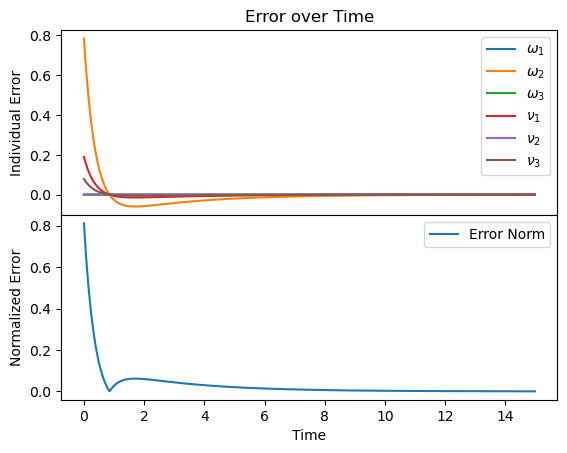

In [377]:
#FUNCTION INPUTS HERE -----------------
#Initial configuration of the end effector reference trajectory
T_se = np.array([[ 0.170, 0, 0.985, 0.387],
                 [ 0, 1, 0,     0],
                 [ -0.985, 0, 0.170, 0.570],
                 [ 0, 0, 0,     1]])

#Rotate the T_se to give us both 30 degree error in angular position and 0.2 error in planar positioning.
tran = np.identity((4))
roty = np.array([[cos(0.785), 0, sin(0.785)],
                 [0, 1, 0],
                 [-sin(0.785), 0, cos(0.785)]])
tran[0:3,0:3] = roty @ tran[0:3,0:3]
tran[0,-1] = 0.2
T_se = T_se @ tran

#Intialize the initial and the final configurations of the cube. 
T_isc = np.array([[ 1, 0, 0,     1],
                  [ 0, 1, 0,     0],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

T_dsc = np.array([[ 0, 1, 0,     0],
                  [-1, 0, 0,    -1],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

#initial configuration
initialRobot = np.array([0, 0, 0, 0, 0, 0.2, -1.6, 0, 0, 0, 0, 0, 0])

#CSV name 
name = "JointLimitovershoot"

#gains
kp = np.identity((6)) * 3
ki = np.identity((6)) * 1

#FUNCTION CALL ------------------------
youBotCube(T_isc, T_dsc, initialRobot, T_se, name, Kp= kp, Ki=ki)

#PLOT THE ERROR DATA ------------------
#import the error data
ename = name + "_error.csv"
errordata = np.loadtxt(ename, delimiter=",", dtype=float)
plotTime = np.asanyarray([*range(errordata.shape[0])]) * .01

#create a plot of the x_error for each individual vector item. 
fig, axs = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(plotTime, errordata[:,0], marker="none", label=r"$\omega_1$")
axs[0].plot(plotTime, errordata[:,1], marker="none", label=r"$\omega_2$")
axs[0].plot(plotTime, errordata[:,2], marker="none", label=r"$\omega_3$")
axs[0].plot(plotTime, errordata[:,3], marker="none", label=r"$\nu_1$")
axs[0].plot(plotTime, errordata[:,4], marker="none", label=r"$\nu_2$")
axs[0].plot(plotTime, errordata[:,5], marker="none", label=r"$\nu_3$")
axs[0].set_ylabel(r"Individual Error")
axs[0].set_title("Error over Time")
axs[0].legend(loc="upper right")

#plot the normalized error against the number of iterations available. 
axs[1].plot(plotTime, np.linalg.norm(errordata, axis=1), label="Error Norm")
axs[1].set_ylabel(r"Normalized Error")
axs[1].set_xlabel(r"Time") 
axs[1].legend(loc="upper right")

# Example: Best Gains + New Task
The best gains were achieved with a P controller with the following gains.

$$

K_P = 
\begin{matrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{matrix}

\quad \quad \quad

K_I = 
\begin{matrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{matrix}

$$

The new location of the cube is 
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Cube Location</th>
    <th class="tg-c3ow">x</th>
    <th class="tg-c3ow">y</th>
    <th class="tg-0pky">phi</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">Initial Position</td>
    <td class="tg-c3ow">-1</td>
    <td class="tg-c3ow">-1</td>
    <td class="tg-0pky">-1.57</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Desired Position</td>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">-1</td>
    <td class="tg-0pky">0.0</td>
  </tr>
</tbody>
</table>

Generating trajectory ...


/var/folders/7w/_9tcnxcs6ld28_h3sl__ch380000gn/T/ipykernel_4876/2357832682.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index != "run":


Trajectory generated!


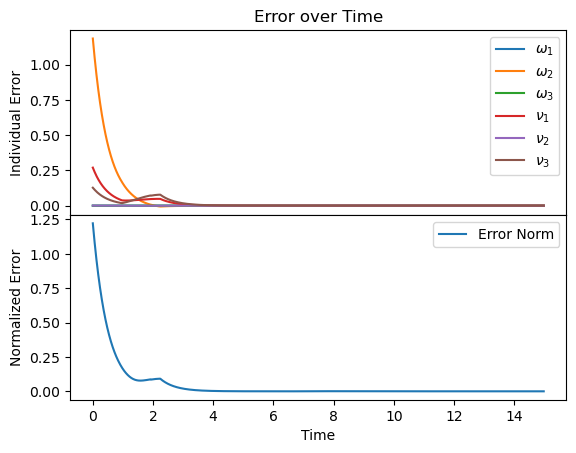

In [375]:
#FUNCTION INPUTS HERE -----------------
#Initial configuration of the end effector reference trajectory
T_se = np.array([[ -0.123, 0.841, 0.526, 0.237],
                 [ 0.191, 0.540, -0.819, -0.368],
                 [ -0.974, 0, -0.227, 0.484],
                 [ 0, 0, 0,     1]])

#Rotate the T_se to give us both 30 degree error in angular position and 0.2 error in planar positioning.
tran = np.identity((4))
roty = np.array([[cos(0.785), 0, sin(0.785)],
                 [0, 1, 0],
                 [-sin(0.785), 0, cos(0.785)]])
tran[0:3,0:3] = roty @ tran[0:3,0:3]
tran[0,-1] = 0.2
T_se = T_se @ tran

#Intialize the initial and the final configurations of the cube. 
T_dsc = np.array([[ 1, 0, 0,     1],
                  [ 0, 1, 0,     0],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

T_isc = np.array([[ 0, 1, 0,     -1],
                  [-1, 0, 0,    0],
                  [ 0, 0, 1, 0.025],
                  [ 0, 0, 0,     1]])

#initial configuration
initialRobot = np.array([-1, 0, 0, 0, 0, 0.2, -1.6, 0, 0, 0, 0, 0, 0])

#CSV name 
name = "JointLimitnewTask"

#gains
kp = np.identity((6)) * 2
ki = np.identity((6)) * 0 

#FUNCTION CALL ------------------------
youBotCube(T_isc, T_dsc, initialRobot, T_se, name, Kp=kp, Ki=ki)

#PLOT THE ERROR DATA ------------------
#import the error data
ename = name + "_error.csv"
errordata = np.loadtxt(ename, delimiter=",", dtype=float)
plotTime = np.asanyarray([*range(errordata.shape[0])]) * .01

#create a plot of the x_error for each individual vector item. 
fig, axs = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(plotTime, errordata[:,0], marker="none", label=r"$\omega_1$")
axs[0].plot(plotTime, errordata[:,1], marker="none", label=r"$\omega_2$")
axs[0].plot(plotTime, errordata[:,2], marker="none", label=r"$\omega_3$")
axs[0].plot(plotTime, errordata[:,3], marker="none", label=r"$\nu_1$")
axs[0].plot(plotTime, errordata[:,4], marker="none", label=r"$\nu_2$")
axs[0].plot(plotTime, errordata[:,5], marker="none", label=r"$\nu_3$")
axs[0].set_ylabel(r"Individual Error")
axs[0].set_title("Error over Time")
axs[0].legend(loc="upper right")

#plot the normalized error against the number of iterations available. 
axs[1].plot(plotTime, np.linalg.norm(errordata, axis=1), label="Error Norm")
axs[1].set_ylabel(r"Normalized Error")
axs[1].set_xlabel(r"Time") 
axs[1].legend(loc="upper right")